# MrVI for 1k+ samples

In this short tutorial, we explore how to apply MrVI to single-cell data containing a very large number of samples. 

Certain core analyses of MrVI are memory intensive. The most notable example is the computation of local sample distances, requiring to store a sample-by-sample distance matrix for many cells.
When the number of samples is very large (1k+), these matrices become too large to be stored for all cells in memory.

In this tutorial, we will illustrate strategies to use MrVI in these settings.
For illustration, we will consider [onek1k](https://onek1k.org/), a PBMC scRNA-seq dataset collected from 1k donors.

The considered dataset here has already been processed (filtered, highly variable gene selection, subsampled to 500 cells per donor to speed up model fitting).


In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

save_dir = tempfile.TemporaryDirectory()

In [1]:
import numpy as np
import scanpy as sc

from scvi.external import MRVI
from sklearn.decomposition import PCA
import pymde
import os
import pandas as pd
import seaborn as sns

/data1/miniconda3/envs/scvi_pinnedjax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
adata_sub.write_h5ad("1konek_subsampled.h5ad")

In [ ]:
save_dir = "deleteme"

In [ ]:
# adata_path = os.path.join(save_dir.name, "1konek_tutorial_subset.h5ad")
adata_path = "1konek_tutorial_subset.h5ad"
adata_sub = sc.read(
    adata_path, backup_url="https://figshare.com/ndownloader/files/28423175"
)

## Model fitting


In [ ]:
MRVI.setup_anndata(adata_sub, sample_key="donor_id", batch_key="pool_number")

train_kwargs = {
    "max_epochs": 200,
    "batch_size": 1024,
    "early_stopping": True,
    "early_stopping_patience": 30,
    "check_val_every_n_epoch": 1,
    "early_stopping_monitor": "elbo_validation",
    "plan_kwargs": {"n_epochs_kl_warmup": 50, "lr": 3e-3},
    "accelerator": "gpu",
}
model = MRVI(adata_sub)
model.train(**train_kwargs)
model.save("mrvi_large_tutorial3")

In [3]:
model = MRVI.load("mrvi_large_tutorial3", adata_sub)

INFO     File mrvi_large_tutorial3/model.pt already downloaded                                                     


INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/data1/miniconda3/envs/scvi_pinnedjax/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/data1/miniconda3/envs/scvi_pinnedjax/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/data1/miniconda3/envs/scvi_pinnedjax/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 1/16:   0%|                                                         | 0/16 [00:00<?, ?it/s]

/data1/miniconda3/envs/scvi_pinnedjax/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:369: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


Epoch 1/16:   6%| | 1/16 [00:13<03:28, 13.88s/it, v_num=1, train_loss_step=2.65e+3, train_loss_ep

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/16:   6%| | 1/16 [00:13<03:28, 13.89s/it, v_num=1, train_loss_step=2.65e+3, train_loss_ep


<Axes: xlabel='epoch'>

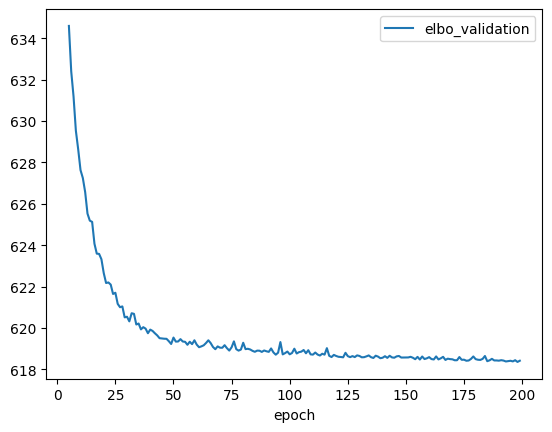

In [4]:
model.history["elbo_validation"][5:].plot()

## Visualizing `MrVI` latent representations

Latent representation computation is seemless for large datasets, and can be done on the entire dataset in the same way as for smaller datasets.

In [13]:
u = model.get_latent_representation(give_z=False)
z = model.get_latent_representation(give_z=True)

_kwargs = {
    "embedding_dim": 2,
    "constraint": pymde.Standardized(),
    "repulsive_fraction": 0.7,
    "verbose": False,
    "n_neighbors": 15,
    "device": "cuda",
}

u_emb = pymde.preserve_neighbors(u, **_kwargs).embed()
z_emb = pymde.preserve_neighbors(z, **_kwargs).embed()

adata_sub.obsm["u_mde"] = u_emb.cpu().numpy()
adata_sub.obsm["z_mde"] = z_emb.cpu().numpy()

100%|███████████████████████████████████████████████████████| 3831/3831 [00:06<00:00, 562.68it/s]


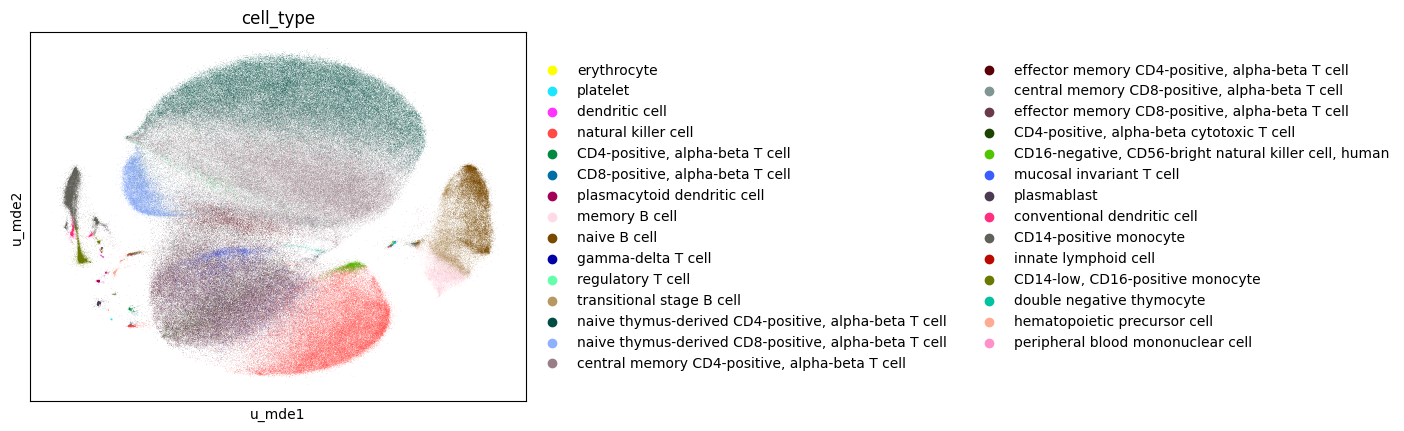

In [14]:
sc.pl.embedding(adata_sub, basis="u_mde", color=["cell_type"])

<Axes: >

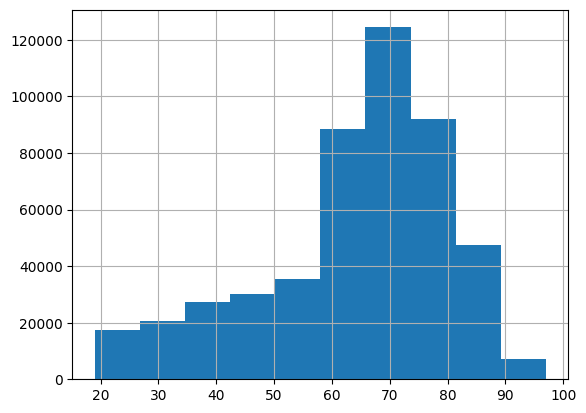

In [22]:
adata_sub.obs["age"].hist()

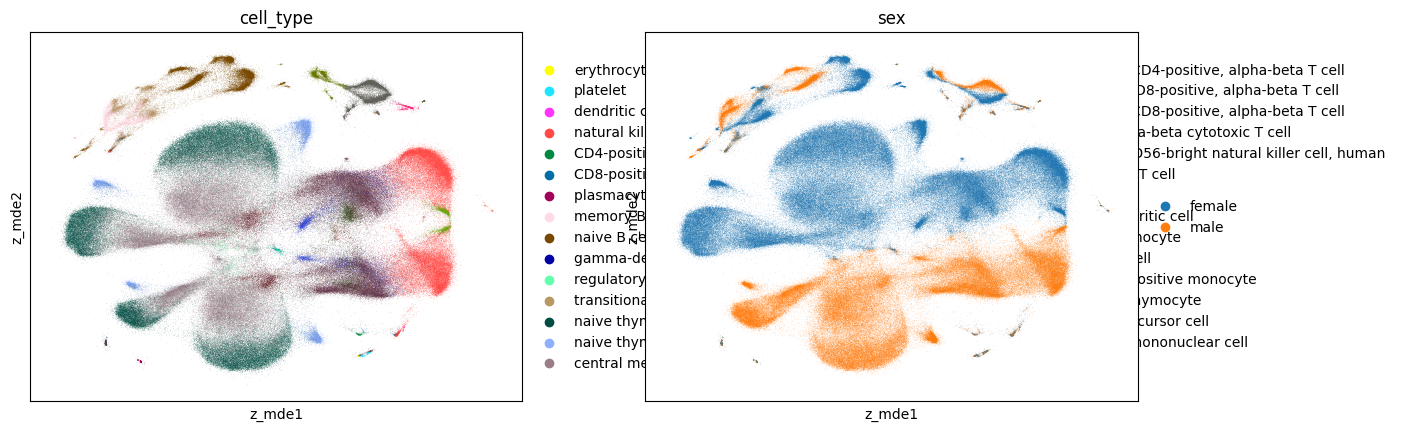

In [24]:
sc.pl.embedding(
    adata_sub,
    basis="z_mde",
    color=["cell_type", "sex"],
)

## Sample stratification

Particular care needs to be taken when computing local sample distances for large datasets.
In particular, the distance matrix is too large to be stored in memory for all cells in the dataset.

For this reason, we recommend two strategies to produce sample stratification.
The first one to stratify samples for identified cell groups, e.g., cell types.
This can typically be done using the following code:

```python
cell_dists = model.get_local_sample_distances(adata_sub, keep_cell=False, batch_size=32, groupby="cell_type")
```
The important parameters here are `keep_cell=False`, which means that the distance matrix won't be computed for each cell, but averaged over cells of the same cell type.
Small values of `batch_size` will also help to reduce memory usage.

The second strategy, that we will cover here, is to compute the distance matrix for a subsample of the dataset.

In [9]:
random_cells = np.random.choice(adata_sub.obs_names, size=3000, replace=False)
adata_sample = adata_sub[random_cells].copy()
cell_dists = model.get_local_sample_distances(
    adata_sample, keep_cell=True, batch_size=32
)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/home/pierre/scvi-tools/src/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 4 in adata.obs['_scvi_sample'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
100%|████████████████████████████████████████████████████████████| 94/94 [01:32<00:00,  1.01it/s]


In [10]:
# clustering selected cells based on distance matrix
dmats = cell_dists["cell"]
n_samples = dmats.shape[1]

where_triu = np.triu(np.ones(n_samples), k=1).astype(bool).flatten()
dmats_u = []
for i in range(dmats.shape[0]):
    dmat_cell = dmats[i].values.flatten()
    dmat_cell = dmat_cell[where_triu]
    dmats_u.append(dmat_cell)
dmats_u = np.array(dmats_u)

In [11]:
cell_reps = PCA(n_components=50).fit_transform(dmats_u)

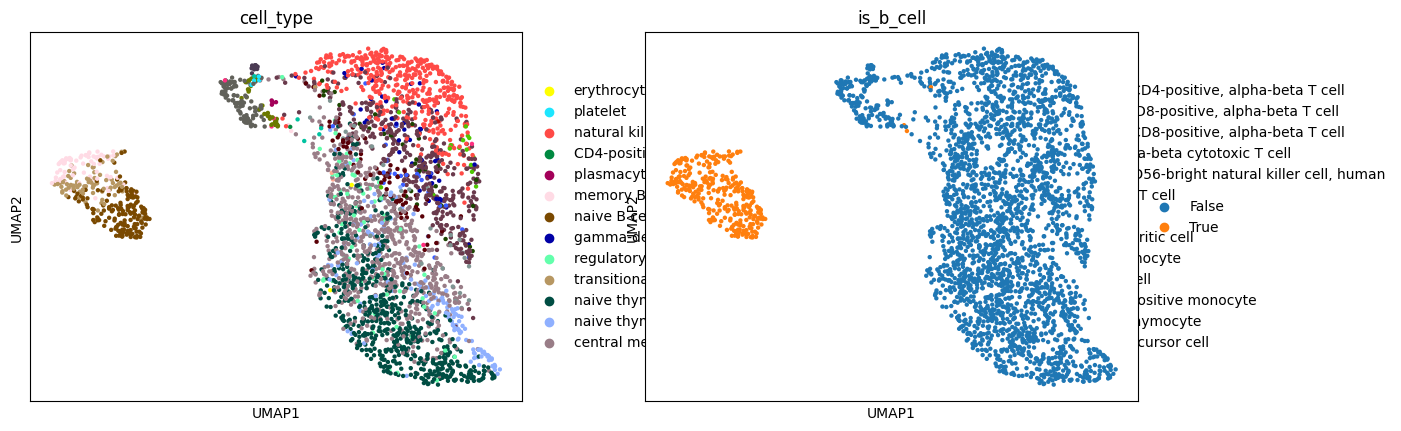

In [12]:
adata_sample.obsm["cell_emb"] = cell_reps
adata_sample.obs["is_b_cell"] = (
    adata_sample.obs["cell_type"].str.contains("B cell").astype(str)
)
sc.pp.neighbors(adata_sample, use_rep="cell_emb")
sc.tl.umap(adata_sample)
sc.pl.embedding(adata_sample, basis="umap", color=["cell_type", "is_b_cell"])

This analysis discriminates B cells from other cell types in the dataset.

Next, we would like to statify samples (and hence compute distance matrices) based on the identified cell groups. This can be done as follows:

In [13]:
adata_sub.obs.loc[:, "cell_group"] = "other"
adata_sub.obs.loc[lambda x: x["cell_type"].str.contains("B cell"), "cell_group"] = (
    "B cells"
)

# this line is required to register the cell_group as a working variable for MrVI
model.update_sample_info(adata_sub)

We can now compute distance matrices for each cell group, being careful to not store the distance matrices for each cell (`keep_cell=False`).

In [16]:
subsample_cells = np.random.choice(adata_sub.obs_names, size=20000, replace=False)
cell_dists = model.get_local_sample_distances(
    adata_sub[subsample_cells], keep_cell=False, batch_size=32, groupby="cell_group"
)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/home/pierre/scvi-tools/src/scvi/external/mrvi/_model.py:356: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)
100%|██████████████████████████████████████████████████████████| 625/625 [10:07<00:00,  1.03it/s]


In [61]:
from matplotlib.colors import to_hex
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering
from scipy.spatial.distance import squareform


def get_sample_colors():
    cmap = sns.color_palette("viridis", as_cmap=True)

    def get_age_colors(x):
        x_ = (int(x) - 20) / 70.0
        x_ = np.clip(x_, 0, 1)
        return to_hex(cmap(x_))

    sex_map = {
        "male": "red",
        "female": "green",
    }
    sample_info = model.sample_info.set_index("donor_id")
    sex_colors = sample_info.sex.map(sex_map).values
    onset_colors = sample_info.age.map(get_age_colors)
    colors = pd.DataFrame(
        {
            "sex": sex_colors,
            "onset": onset_colors,
        }
    )
    return colors


def get_dendrogram(dists):
    ds = squareform(dists)
    Z = linkage(ds, method="ward")
    Z = optimal_leaf_ordering(Z, ds)
    return Z

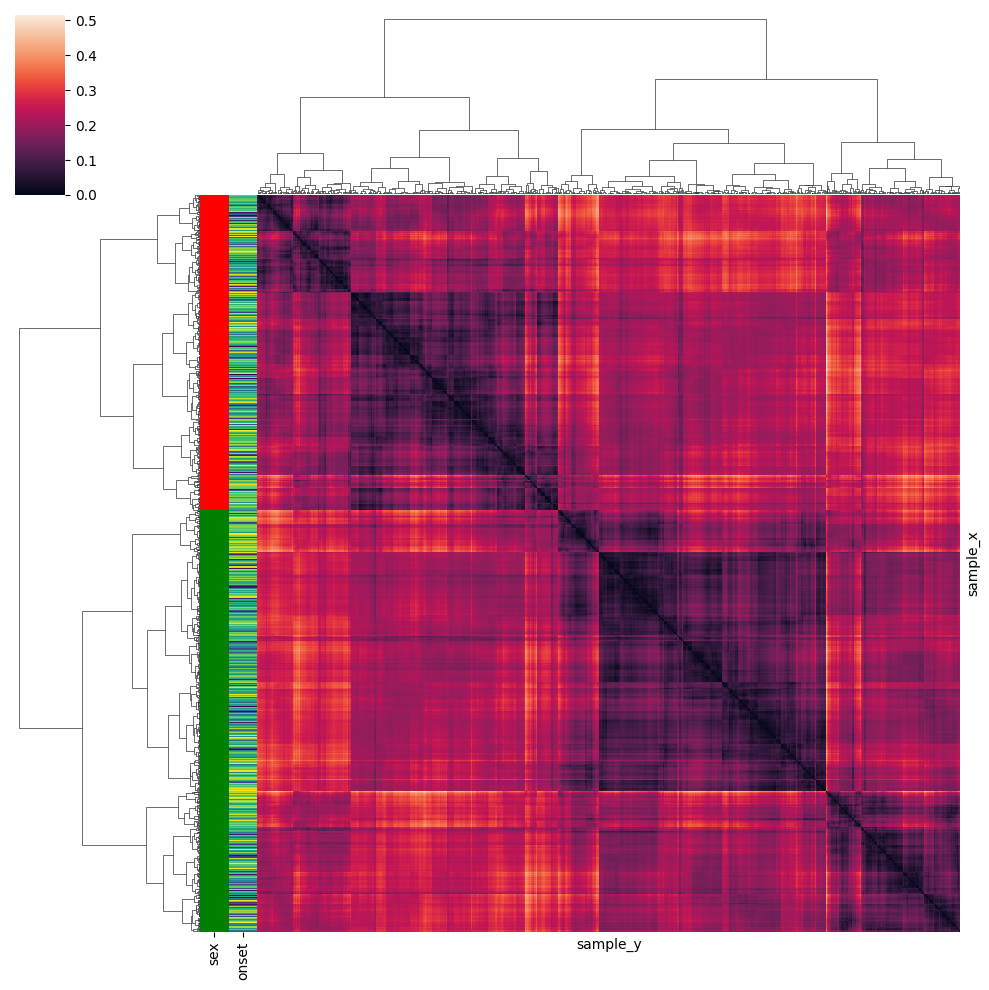

In [63]:
d1 = cell_dists.loc[{"cell_group_name": "B cells"}].cell_group
Z = get_dendrogram(d1)
colors = get_sample_colors()

sns.clustermap(
    d1.to_pandas(),
    row_linkage=Z,
    col_linkage=Z,
    xticklabels=False,
    yticklabels=False,
    row_colors=colors,
)

## Differential expression

Differential expression can be computed on a subset of the data in the case where the dataset is very large.
Here, a critical consideration is to adjust `batch_size` to avoid memory issues induced by the large number of samples.

In [8]:
adata_b_cells = adata_sub[adata_sub.obs["cell_type"].str.contains("B cell")]
adata_b_cells

View of AnnData object with n_obs × n_vars = 49122 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'donor_id', 'pool_number', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'age', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 

In [11]:
sample_cov_keys = ["sex"]
model.sample_info["sex"] = model.sample_info["sex"].cat.reorder_categories(
    ["female", "male"]
)

# subsample the data for prototyping, remove in the case where DE is required for the full dataset
b_cells_to_use = np.random.choice(adata_b_cells.obs_names, size=2000, replace=False)
de_res = model.differential_expression(
    adata_b_cells[b_cells_to_use],
    sample_cov_keys=sample_cov_keys,
    store_lfc=True,
    use_vmap=False,
    batch_size=8,  # here, we use a batch size of 8 to avoid memory issues
)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/home/pierre/scvi-tools/src/scvi/external/mrvi/_model.py:1205: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sample_cov_keys=sample_cov_keys,
/home/pierre/scvi-tools/src/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 17 in adata.obs['_scvi_sample'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 691.33it/s]


100%|██████████████████████████████████████████████████████████| 250/250 [03:40<00:00,  1.14it/s]
